### Resumen

En este notebook usaremos la función **EigenFaceRecognizer_create()** incluido en el paquete OpenCV, para realizar la operación de reconocimiento facial

In [1]:
# Imports básicos
import imutils
import os
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt

In [2]:
# Versiones de los paquetes usados en este notebook
%reload_ext watermark
%watermark -a "César S. Hooper/ Nov 2021" --iversions

Author: César S. Hooper/ Nov 2021

numpy  : 1.19.5
pandas : 1.2.4
imutils: 0.5.4
cv2    : 4.5.4-dev



## Procedimiento

Para realizar reconocimiento facial en este notebook, usando la función **EigenFaceRecgnizer_create()** de OpenCV, se realizaron los siguientes pasos
* Se grabaron dos videos en formato mp4 de dos personas. Aproximadamente 12 segundos con cámara de teléfono celular con toma de 60fps
* Se recolectaron 345 frames de cada uno de esos videos. Total 690 frames.
* Los frames albo se marcaron con el índice 1 y los no albo con el índice 0
* Se entrenó la función EigenFaceRecognizer_create y se guardó el modelo
* Se hicieron predicciones con el modelo entrenado

In [5]:
datapath = 'C:/Users/Cesar Hooper/Desktop/github/reconocimiento_facial/data'
persopath = datapath + '/cesar'

### Lectura de los datos
Ahora, usaremos una función para detectar los rostros, luego almacenamos la parte seleccionada para el entrenamiento posterior. 

In [29]:
# Cargamos los videos y seleccionamos 345 frames que guardamos en carpetas diferentes.

if not os.path.exists(persopath):
    print('Creando carpeta', persopath)
    os.mkdir(persopath)

cap = cv2.VideoCapture('cesar.mp4')

# CascadeClassifier nos ayudará a detectar los rostros
faceclassif = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
caras = []
count = 0
while True:
    ret, frame = cap.read()
    if ret == False: break
    
    # redimensionamos los frames usando imutils y los pasamos al gris
    frame = imutils.resize(frame, width=500)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    auxframe = frame.copy()
    
    # usamos detecMultiScale() para detectar las coordenadas de los rostros
    faces = faceclassif.detectMultiScale(gray, 1.3,5)
    
    for faz in faces:
        x,y,w,h = faz
                
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0),2)
        rostro = auxframe[y:y+h, x:x+w]
        rostro =cv2.resize(rostro, (100, 100), interpolation=cv2.INTER_CUBIC)
        cv2.imwrite(persopath + '/rostro' + str(count) + '.jpg', rostro)
    
    
    cv2.imshow('frame', frame)
        
    count += 1
    k = cv2.waitKey(1)
    if k == 27 or count >= 345: break
    
    
    
cap.release()
cv2.destroyAllWindows()

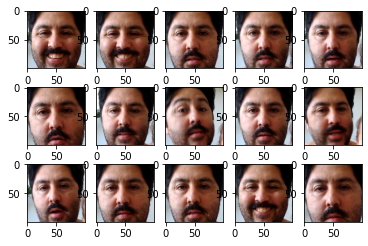

In [28]:
# aquí una muestra de 15 frames seleccionados al azar.
k = 1
for foto in np.random.choice(os.listdir(persopath), 15):
    img = plt.imread(persopath + '/' + foto)
    plt.subplot(3,5,k)
    plt.imshow(img)
    k += 1 

###  Creación del Modelo
Recordar que estamos utilizando dos fuentes de rostros (de personas  diferentes).
Seleccionamos 345 frames de esas fuentes y las almacenamos en dos directorios con sus nombres.
Ahora, vamos a cargar cada uno de esos frames, asignarles el valor 1 a la variable target y 0 a la otra variable

In [30]:
# Creamos las listas labels y facedata para almacenar los frames con sus respectivos labels (0 ó 1)
datapath = 'C:/Users/Cesar Hooper/Desktop/github/reconocimiento_facial/data'
peoplelist = os.listdir(datapath)
labels = []
facesdata = []
label = 1

# data frame con los datos
datos = pd.DataFrame()

for namedir in peoplelist:
    
    personpath = datapath + '/' + namedir
    
    for filename in os.listdir(personpath):
        
        labels.append(label)
        facesdata.append(cv2.imread(personpath+'/'+filename, 0))
        image = cv2.imread(personpath+'/'+filename, 1)
    label -= 1

# vamos a desordenar aleatoriamente los datos
datos['facesdata'] = facesdata
datos['labels'] = labels
datos = datos.sample(n=690, random_state=300)

# creando el modelo
face_recognizer = cv2.face.EigenFaceRecognizer_create()

print('training ... ')

face_recognizer.train(list(datos.facesdata), np.array(list(datos.labels)))

# almacenamiento del modelo
face_recognizer.write('modeloEigenFace.xml')

print('modelo almacenado')


training ... 
modelo almacenado


In [ ]:
Una vez creado el modelo y almacenado, lo cargamos para hacer predicciones y el reconocimiento facial.

In [13]:
datapath = 'C:/Users/Cesar Hooper/Desktop/github/reconocimiento_facial/data'
imagepath = os.listdir(datapath)

face_recognizer = cv2.face.EigenFaceRecognizer_create()


# leyendo el modelo
face_recognizer.read('modeloEigenFace.xml')

cap = cv2.VideoCapture(0) #'cesar_test.mp4'

faceclassif = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
i = 0
while True:
    ret, frame = cap.read()
    
    if ret == False:
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    auxframe = gray.copy()

    faces = faceclassif.detectMultiScale(gray, 1.3, 5)

    for faz in faces:
        x,y,h,w = faz
        rostro = auxframe[y:y+h, x:x+w]
        rostro = cv2.resize(rostro, (100,100), interpolation=cv2.INTER_CUBIC)
        result = face_recognizer.predict(rostro)
        
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0),2)
             
        
        
        # Con este modelo, si el resultado result[1] es menor de 5700 entonces 
        if result[1] < 5700:
            cv2.putText(frame, '{}'.format(imagepath[1]), (x,y-5), 1,1.3,(255,255,0),1,cv2.LINE_AA)
        else:
            cv2.putText(frame, '{}'.format(imagepath[0]), (x,y-5), 1,1.3,(255,255,0),1,cv2.LINE_AA)
    
    cv2.imshow('frame', frame)
    
    if i <=30:
        cv2.imwrite('recog_cesar_'+str(i)+'.jpg',frame) 
    i+=1
    k = cv2.waitKey(1)
    if k == 27: break

cap.release()
cv2.destroyAllWindows

<function destroyAllWindows>

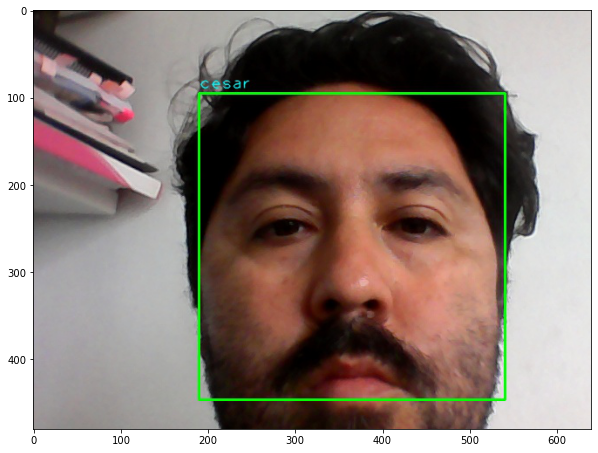

In [20]:
#Aquí una muestra de 1 frames con reconocimiento facial
path = 'C:/Users/Cesar Hooper/Desktop/github/reconocimiento_facial'
lista = [dato for dato in os.listdir(path) if dato[-3:]=='jpg']

k = 1
for foto in np.random.choice(lista, 1):
    img = plt.imread(path + '/' + foto)
    plt.figure(figsize=(10,10))
    plt.subplot(1,1,k)
    plt.imshow(img)
    k += 1 

In [ ]:
## ANEXO: Método alternativo para capturar y almacenar los frames de los videos

cap = cv2.VideoCapture('cesar.mp4')
i=0
while (cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite('cesar_'+str(i)+'.jpg',frame)
    if i >=10: break
    i+=1
    

cap.release()
cv2.destroyAllWindows()